In [3]:
from PIL import Image, ImageFilter
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
from pathlib import Path
import random
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import cv2

In [4]:
base_path = "data/100"

# Get tumour file paths and shuffle
tumour_files = []
tumour_dirs = [
    "Invasive_Tumor",
    "Prolif_Invasive_Tumor",
    "T_Cell_and_Tumor_Hybrid"
]

for dir_name in tumour_dirs:
    dir_path = os.path.join(base_path, dir_name)
    if os.path.isdir(dir_path):
        files = [os.path.join(dir_path, f) for f in os.listdir(dir_path)]
        tumour_files.extend(files)

random.shuffle(tumour_files)

# Get immune file paths and shuffle
immune_files = []
immune_dirs = [
    "CD4+_T_Cells", "CD4+_T_Cells", 
    "CD8+_T_Cells", 
    "B_Cells", 
    "Mast_Cells", 
    "Macrophages_1", 
    "Macrophages_2", 
    "LAMP3+_DCs",
    "IRF7+_DCs"
]

for dir_name in immune_dirs:
    dir_path = os.path.join(base_path, dir_name)
    if os.path.isdir(dir_path):
        files = [os.path.join(dir_path, f) for f in os.listdir(dir_path)]
        immune_files.extend(files)

random.shuffle(immune_files)


# Get stromal file paths and shuffle
stromal_files = []
stromal_dirs = [
    "Stromal", 
    "Stromal_and_T_Cell_Hybrid", 
    "Perivascular-Like"
]

for dir_name in stromal_dirs:
    dir_path = os.path.join(base_path, dir_name)
    if os.path.isdir(dir_path):
        files = [os.path.join(dir_path, f) for f in os.listdir(dir_path)]
        stromal_files.extend(files)

random.shuffle(stromal_files)

# Get other file paths and shuffle
other_files = []
other_dirs = [
    "Endothelial",
    "Myoepi_ACTA2+", 
    "Myoepi_KRT15+", 
    "DCIS_1", 
    "DCIS_2", 
]

for dir_name in stromal_dirs:
    dir_path = os.path.join(base_path, dir_name)
    if os.path.isdir(dir_path):
        files = [os.path.join(dir_path, f) for f in os.listdir(dir_path)]
        other_files.extend(files)

random.shuffle(other_files)


In [5]:
def load_resize(img_path, size=(224,224)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(size)
    return np.array(img)

In [6]:
tumour_imgs = [load_resize(f) for f in tumour_files]
print("tumour loaded")

immune_imgs = [load_resize(f) for f in immune_files]
print("immune loaded")

stromal_imgs = [load_resize(f) for f in stromal_files]
print("stromal loaded")

other_imgs = [load_resize(f) for f in other_files]
print("other loaded")

# Train using 80% of data from each group
'''
tumour_train_ind = int(0.8 * len(tumour_imgs))
tumour_test_ind = int(0.2 * len(tumour_imgs))

immune_train_ind = int(0.8 * len(immune_imgs))
immune_test_ind = int(0.2 * len(immune_imgs))

stromal_train_ind = int(0.8 * len(stromal_imgs))
stromal_test_ind = int(0.2 * len(stromal_imgs))

other_train_ind = int(0.8 * len(other_imgs))
other_test_ind = int(0.2 * len(other_imgs))
'''

tumour_train_ind = 5000
tumour_test_ind = 6000

immune_train_ind = 5000
immune_test_ind = 6000

stromal_train_ind = 5000
stromal_test_ind = 6000

other_train_ind = 5000
other_test_ind = 6000

imgs_train = immune_imgs[:immune_train_ind] + tumour_imgs[:tumour_train_ind] + stromal_imgs[:stromal_train_ind] + other_imgs[:other_train_ind]
imgs_test = immune_imgs[immune_train_ind:immune_test_ind] + tumour_imgs[tumour_train_ind:tumour_test_ind] + stromal_imgs[stromal_train_ind:stromal_test_ind] + other_imgs[other_train_ind:other_test_ind]

Xmat_train_og = np.stack(imgs_train, axis=0)
Xmat_test = np.stack(imgs_test, axis=0)

y_train = ['Immune'] * immune_train_ind + ['Tumour'] * tumour_train_ind + ['Stromal'] * stromal_train_ind + ['Other'] * other_train_ind
y_test = ['Immune'] * immune_test_ind + ['Tumour'] * tumour_test_ind + ['Stromal'] * stromal_test_ind + ['Other'] * other_test_ind

tumour loaded
immune loaded
stromal loaded
other loaded


In [10]:
def apply_blur(images, kernel_size):
    return np.array([cv2.GaussianBlur(img, kernel_size, 0) for img in images])

def apply_greyscale(images):
    greyscale = []
    for img in images:
        pil_img = Image.fromarray(img)
        grey = pil_img.convert("L")
        grey_3ch = grey.convert("RGB")
        greyscale.append(np.array(grey_3ch))
    return np.array(greyscale)

def adjust_contrast(images, factor=1.5):
    adjusted = []
    for img in images:
        pil_img = Image.fromarray(img)
        enhancer = ImageEnhance.Contrast(pil_img)
        contrasted = enhancer.enhance(factor)
        adjusted.append(np.array(contrasted))
    return np.array(adjusted)

In [11]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [13]:
class NumpyImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = Image.fromarray((image * 255).astype('uint8'))  # Convert to PIL Image

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = NumpyImageDataset(Xmat_train_og, y_train_enc, transform=transform)
test_dataset = NumpyImageDataset(Xmat_test, y_test_enc, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128)

In [12]:
# Train model with no augmentations
tf.keras.backend.clear_session()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Freeze feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 10
num_epochs_og = num_epochs
losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = outputs.max(1)  # Get class with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 1.0964, Accuracy: 0.4878
Epoch 2, Loss: 1.0438, Accuracy: 0.5151
Epoch 3, Loss: 1.0325, Accuracy: 0.5274
Epoch 4, Loss: 1.0228, Accuracy: 0.5363
Epoch 5, Loss: 1.0097, Accuracy: 0.5344
Epoch 6, Loss: 1.0210, Accuracy: 0.5347
Epoch 7, Loss: 1.0010, Accuracy: 0.5475
Epoch 8, Loss: 1.0070, Accuracy: 0.5406
Epoch 9, Loss: 1.0000, Accuracy: 0.5457
Epoch 10, Loss: 0.9964, Accuracy: 0.5453


Original Accuracy: 25.68%


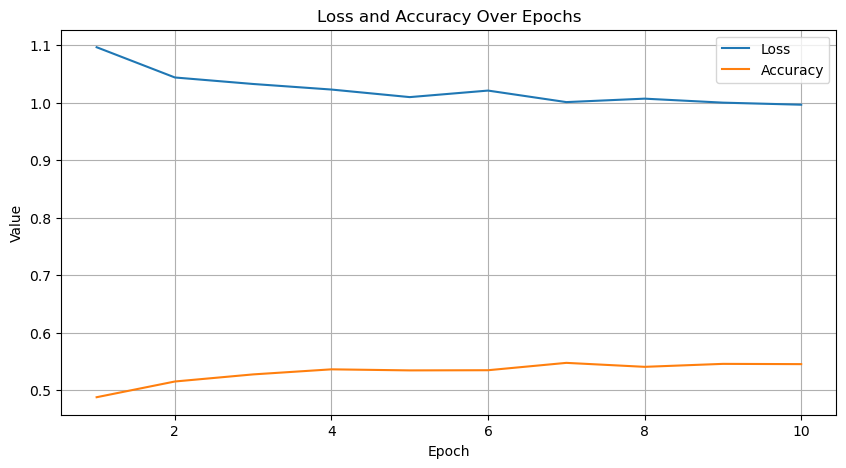

In [28]:
losses_og = losses
accuracies_og = accuracies

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Pick class with highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

original_accuracy = 100 * correct / total
print(f"Original Accuracy: {original_accuracy:.2f}%")

# After training, plot loss and accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), losses, label='Loss')
plt.plot(range(1, num_epochs+1), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss and Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Test with 5x5 blur augmentation
Xmat_train = apply_blur(Xmat_train_og, (5,5))
train_dataset = NumpyImageDataset(Xmat_train, y_train_enc, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)

tf.keras.backend.clear_session()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 5
num_epochs_blur5 = num_epochs
losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = outputs.max(1)  # Get class with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

blur5_accuracies = accuracies
blur5_losses = losses

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 1.1071, Accuracy: 0.4852
Epoch 2, Loss: 1.0518, Accuracy: 0.5099


In [ ]:
# Evaluate Model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Pick class with highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

blur5_accuracy = 100 * correct / total
print(f"Blur 5 Accuracy: {blur5_accuracy:.2f}%")

# After training, plot loss and accuracy graph
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), losses, label='Loss')
plt.plot(range(1, num_epochs+1), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Blur 5: Loss and Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Test with 15x15 blur augmentation
Xmat_train = apply_blur(Xmat_train_og, (15,15))
train_dataset = NumpyImageDataset(Xmat_train, y_train_enc, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)

print("Augmentation completed")

tf.keras.backend.clear_session()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

print("Begin training")

num_epochs = 5
num_epochs_blur15 = num_epochs
losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = outputs.max(1)  # Get class with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

blur15_accuracies = accuracies
blur15_losses = losses

In [ ]:
# Evaluate Model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Pick class with highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

blur15_accuracy = 100 * correct / total
print(f"Blur 15 Accuracy: {blur15_accuracy:.2f}%")

# After training, plot loss and accuracy graph
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), losses, label='Loss')
plt.plot(range(1, num_epochs+1), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Blur 15: Loss and Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Test with 25x25 blur augmentation
Xmat_train = apply_blur(Xmat_train_og, (25,25))
train_dataset = NumpyImageDataset(Xmat_train, y_train_enc, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)

print("Augmentation completed")

tf.keras.backend.clear_session()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

print("Begin training")

num_epochs = 5
num_epochs_blur25 = num_epochs
losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = outputs.max(1)  # Get class with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

blur25_accuracies = accuracies
blur25_losses = losses

In [ ]:
# Evaluate Model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Pick class with highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

blur25_accuracy = 100 * correct / total
print(f"Blur 25 Accuracy: {blur15_accuracy:.2f}%")

# After training, plot loss and accuracy graph
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), losses, label='Loss')
plt.plot(range(1, num_epochs+1), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Blur 25: Loss and Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Test with greyscale augmentation
Xmat_train = apply_greyscale(Xmat_train_og)
train_dataset = NumpyImageDataset(Xmat_train, y_train_enc, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)

tf.keras.backend.clear_session()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 5
num_epochs_greyscale = num_epochs
losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = outputs.max(1)  # Get class with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

grey_accuracies = accuracies
grey_losses = losses

In [ ]:
# Evaluate Model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Pick class with highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

grey_accuracy = 100 * correct / total
print(f"Greyscale Accuracy: {grey_accuracy:.2f}%")

# After training, plot loss and accuracy graph
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), losses, label='Loss')
plt.plot(range(1, num_epochs+1), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Greyscale: Loss and Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Test with contrast 0.5 augmentation
Xmat_train = adjust_contrast(Xmat_train_og, 0.5)
train_dataset = NumpyImageDataset(Xmat_train, y_train_enc, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)

tf.keras.backend.clear_session()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 5
num_epochs_contrast05 = num_epochs
losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = outputs.max(1)  # Get class with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

contrast05_accuracies = accuracies
contrast05_losses = losses

In [ ]:
# Evaluate Model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Pick class with highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

contrast05_accuracy = 100 * correct / total
print(f"Contrast 0.5 Accuracy: {contrast05_accuracy:.2f}%")

# After training, plot loss and accuracy graph
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), losses, label='Loss')
plt.plot(range(1, num_epochs+1), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Contrast 0.5: Loss and Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Test with contrast 1.5 augmentation
Xmat_train = adjust_contrast(Xmat_train_og, 1.5)
train_dataset = NumpyImageDataset(Xmat_train, y_train_enc, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)

tf.keras.backend.clear_session()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 5
num_epochs_contrast15 = num_epochs
losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = outputs.max(1)  # Get class with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

contrast15_accuracies = accuracies
contrast15_losses = losses

In [ ]:
# Evaluate Model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Pick class with highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

contrast15_accuracy = 100 * correct / total
print(f"Contrast 1.5 Accuracy: {contrast15_accuracy:.2f}%")

# After training, plot loss and accuracy graph
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), losses, label='Loss')
plt.plot(range(1, num_epochs+1), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Contrast 1.5: Loss and Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()